In [30]:
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import numpy as np
import importlib
import sklearn
import pickle
import random
import torch
import math
import copy

# from socialSigLayers import *
import socialSigLayers
importlib.reload(socialSigLayers)

<module 'socialSigLayers' from '/Users/heatherbaier/Desktop/CAOE/sig/socialSigLayers.py'>

In [31]:
####### Load our Data
from sklearn import preprocessing
devSet = pd.read_csv("us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)


In [32]:
x_train, y_train, x_val, y_val = socialSigLayers.train_val_split(X, y, .80)

In [33]:
devSet.head()

,sending,sending_citizen_unspecified,sending_citizenship_unknown,sending_household_not_owned,sending_household_owned,sending_household_owned_unknown,sending_indigeneity,sending_internet,sending_internet_unknown,sending_marriage_unknown,...,sending_unknown_employment_status,sending_unknown_indigeneity,sending_unpaid_worker,sending_urban,sending_weighted_avg_income,sending_weighted_avg_income_abroad,sending_weighted_avg_no_income_abroad,sending_weighted_avg_unknown_income_abroad,sending_widowed,US_MIG_05_10
0,10001,1134.995083,243.827586,1178.209016,1106.832815,736.562500,918.960526,2111.233685,347.698113,576.362069,...,1218.357143,840.339623,0,1597.239059,1124.200953,768.788518,1213.505104,1931.825000,460.430041,961
1,10002,917.067746,600.000000,1274.160656,795.118020,-1.000000,-1.000000,1988.103175,459.166667,342.800000,...,535.750000,576.379310,0,-1.000000,908.782316,720.767123,929.317603,845.567568,745.377359,154
2,10003,637.977315,557.150000,729.454795,610.791414,468.392857,584.454545,1310.462428,514.312500,3800.000000,...,540.000000,629.215385,0,-1.000000,628.585520,486.116034,738.533015,-1.000000,276.569767,905
3,10004,1178.378744,1678.562500,1560.244328,1084.109969,785.742857,1165.943463,2109.431851,1043.500000,549.695652,...,771.400000,694.579439,0,1436.934837,1173.751889,861.385645,1219.547797,1643.137255,741.363985,225
4,10005,2231.128863,2916.538705,2104.943216,2278.834178,2353.519005,2527.268790,3075.771459,1941.578834,650.206897,...,1531.622086,2064.311411,0,2319.113608,2230.022635,1672.340116,2273.630651,3946.180995,1241.236982,1071


In [34]:
#y - 'number_moved'
#x - 'everything else that is or can be represented as a float.'

####### Build and fit the Model
model = socialSigLayers.SocialSigNet(X=X)
lr = 1e-4
batchSize = 200

In [35]:
for name, param in model.named_parameters():
    if name != 'SocialSig.W':
        param.requires_grad = False

In [36]:
for name, param in model.named_parameters():
    if param.requires_grad != False:
        print(name)

SocialSig.W


In [37]:
criterion = torch.nn.MSELoss(reduction='sum')
# optimizer = torch.optim.SGD(model.parameters(), lr = lr)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Adam

In [38]:
def train_model(model, criterion, optimizer, lr, batchSize, num_epochs):

    losses = []
    maes = []

    best_mae = 100000000

    for t in range(num_epochs):

        for phase in ['train', 'val']:

            if phase == 'train':

                #Batches
                batchObs = random.sample(range(0, len(y_train)), batchSize)
                # batchObs = [i for i in range(0, 5)]
                modelX = x_train[batchObs]
                # print(modelX.shape)
                modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
                modely = torch.tensor(y_train[batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
                
                y_pred = model(modelX, t)
                loss = criterion(y_pred, modely)  
                
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                grad = torch.autograd.grad(outputs=loss, inputs=modelX, retain_graph = True)
                # print("    GRADIENT: ", grad[0][0].shape)
                # print("    GRADIENT: ", grad[0])
                loss.backward()
                optimizer.step()
                # https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
                with torch.no_grad():
                    for name, p in model.named_parameters():
                        if name == 'SocialSig.W':
                        # print("    In with:        ", p.data)
                            new_val = socialSigLayers.update_function(p, grad[0], loss, lr)
                        # print("NEW WEIGHTS: ", new_val)
                            p.copy_(new_val)

                print("EPOCH: ", t)
                # print("    Train")
                epoch_mae = socialSigLayers.mae(y_pred, modely).item()
                print("    TRAIN    Loss:   ", loss.item(), "     MAE:   ", epoch_mae)

            if phase == 'val':

                #Batches
                batchObs = random.sample(range(0, len(y_val)), batchSize)
                modelX = x_val[batchObs]
                modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
                modely = torch.tensor(y_val[batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
                
                # Perform evaluations of the batch predictions
                y_pred = model(modelX, t)
                loss = criterion(y_pred, modely)  
                epoch_mae = socialSigLayers.mae(y_pred, modely).item()
                print("    VAL      Loss:   ", loss.item(), "     MAE:   ", epoch_mae)

                if epoch_mae < best_mae:
                    
                    best_mae = epoch_mae
                    best_model_wts = copy.deepcopy(model.state_dict())
                    model_name = './models/test_Epoch' + str(t) + '.sav'
                    pickle.dump(model, open(model_name, 'wb'))

                losses.append(loss.item())
                maes.append(epoch_mae)
                
        print("\n")

    print("TRAINING COMPLETE")
    print("Best MAE: ", best_mae)

    # print(best_model_wts)

    # return model.load_state_dict(best_model_wts)
    return best_model_wts, losses, maes

In [39]:
model_ft, losses, maes = train_model(model, criterion, optimizer, lr, batchSize, 10)

/Users/heatherbaier/anaconda/envs/caoe/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/heatherbaier/Desktop/CAOE/sig/socialSigLayers.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/heatherbaier/anaconda/envs/caoe/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
EPOCH:  0
    TRAIN    Loss:    63786172.0      MAE:    316.002868

In [40]:
# print("Model.parameters")
# print(model.parameters)
# print("SSParam")
# print(list(model.SocialSig.parameters()))
# print("is_leaf")
# print(list(model.SocialSig.parameters())[0].is_leaf)
# print("gradfn")
# print(list(model.SocialSig.parameters())[0].grad_fn)
# print("Grad")
# print(list(model.SocialSig.parameters())[0].grad)

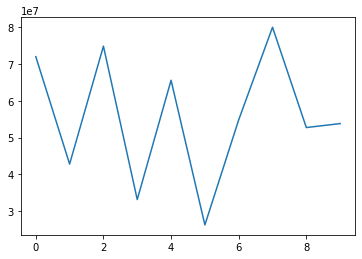

In [41]:
plt.plot([i for i in range(0, 10)], losses)

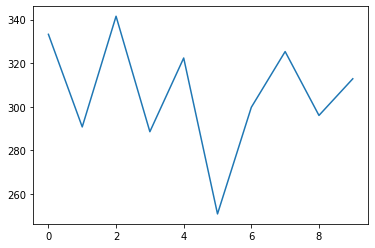

In [42]:
plt.plot([i for i in range(0, 10)], maes)

In [43]:
def show_image(best_epoch):
    df = pd.read_csv("./figs/im" + str(best_epoch) + ".csv")
    df["0"] = df["0"].str.split("(").str[1].str.split(",").str[0].astype(float)
    plt.imshow(np.reshape(np.array(df["0"]), (10, 10)))

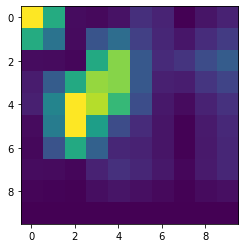

In [24]:
show_image(10)

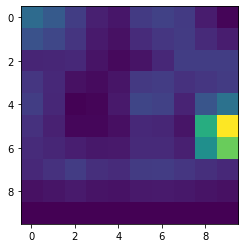

In [25]:
show_image(0)

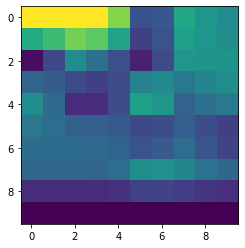

In [26]:
show_image(1)

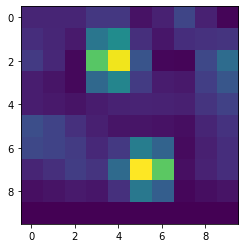

In [27]:
show_image(2)

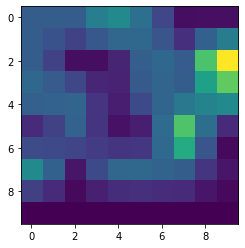

In [28]:
show_image(3)

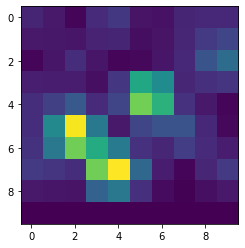

In [29]:
show_image(4)

In [ ]:
def scale(x, out_range=(0, 29)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    to_ret = y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2
    return to_ret.astype(int)